## 将第一节课实践的DCGAN代码改成lsgan的损失函数

可以看下有提示的地方。

In [ ]:
#导入一些必要的包
import os
import random
import paddle 
import paddle.nn as nn
import paddle.optimizer as optim
import paddle.vision.datasets as dset
import paddle.vision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
dataset = paddle.vision.datasets.MNIST(mode='train', 
                                        transform=transforms.Compose([
                                        # resize ->(32,32)
                                        transforms.Resize((32,32)),
                                        # 归一化到-1~1
                                        transforms.Normalize([127.5], [127.5])#((0-127.5)/127.5=-1,(255-127.5)/127.5=1)
                                    ]))

dataloader = paddle.io.DataLoader(dataset, batch_size=32,
                                  shuffle=True, num_workers=4)

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


In [ ]:
#参数初始化的模块
@paddle.no_grad()
def normal_(x, mean=0., std=1.):
    temp_value = paddle.normal(mean, std, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def uniform_(x, a=-1., b=1.):
    temp_value = paddle.uniform(min=a, max=b, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def constant_(x, value):
    temp_value = paddle.full(x.shape, value, x.dtype)
    x.set_value(temp_value)
    return x

#不同层参数初始化
def weights_init(m):
    classname = m.__class__.__name__
    #卷积层初始化
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        normal_(m.weight, 0.0, 0.02)
    #BN层初始化
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight, 1.0, 0.02)
        constant_(m.bias, 0)

In [ ]:
# Generator Code
#生成器
class Generator(nn.Layer):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            #转置卷积：上采样
            # input is Z, [B, 100, 1, 1] -> [B, 64 * 4, 4, 4]
            #输入维度100，输出通道数64*4=256，卷积核大小4*4，步长为1，no padding
            nn.Conv2DTranspose(100, 64 * 4, 4, 1, 0, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            #生成器使用ReLu激活函数
            nn.ReLU(True),
            # state size. [B, 64 * 4, 4, 4] -> [B, 64 * 2, 8, 8]
            nn.Conv2DTranspose(64 * 4, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.ReLU(True),
            # state size. [B, 64 * 2, 8, 8] -> [B, 64, 16, 16]
            nn.Conv2DTranspose( 64 * 2, 64, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64),
            nn.ReLU(True),
            # state size. [B, 64, 16, 16] -> [B, 1, 32, 32]
            nn.Conv2DTranspose( 64, 1, 4, 2, 1, bias_attr=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

#定义模型
netG = Generator()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#参数初始化
netG.apply(weights_init)

# Print the model
#打印模型结构
print(netG)

Generator(
  (gen): Sequential(
    (0): Conv2DTranspose(100, 256, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU(name=True)
    (3): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (4): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (5): ReLU(name=True)
    (6): Conv2DTranspose(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (7): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (8): ReLU(name=True)
    (9): Conv2DTranspose(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (10): Tanh()
  )
)


In [ ]:
#判别器
class Discriminator(nn.Layer):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            #卷积：下采样
            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, 4, 2, 1, bias_attr=False),
            #判别器使用LeakyReLu函数
            nn.LeakyReLU(0.2),

            # state size. [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.LeakyReLU(0.2),

            # state size. [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(64 * 2, 64 * 4, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.LeakyReLU(0.2),

            # state size. [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(64 * 4, 1, 4, 1, 0, bias_attr=False),
            # 这里为需要改变的地方
            #nn.Sigmoid()#MSE不需要输出在(0,1)之间
        )

    def forward(self, x):
        return self.dis(x)

netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2D(1, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (3): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (6): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2D(256, 1, kernel_size=[4, 4], data_format=NCHW)
  )
)


In [ ]:
# Initialize BCELoss function
# 这里为需要改变的地方
#loss = nn.BCELoss()#二分类交叉熵损失log(x)+log(1-x)
loss=nn.MSELoss()#均方误差损失(x-a)^2

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#100维的噪声
fixed_noise = paddle.randn([32, 100, 1, 1], dtype='float32')

# Establish convention for real and fake labels during training
#真为1，假为0
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
#建立Adam优化器
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)


Epoch ID=0 Batch ID=0 

 D-Loss=0.06875340640544891 G-Loss=0.6762298941612244


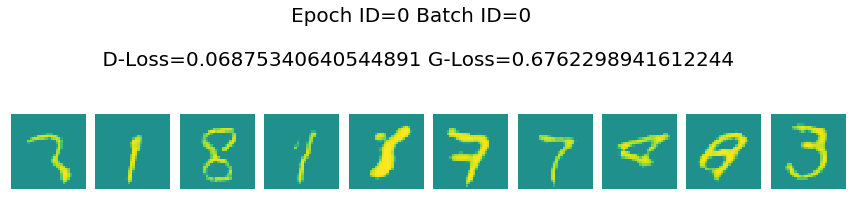

Epoch ID=0 Batch ID=100 

 D-Loss=0.025118103250861168 G-Loss=1.0886119604110718


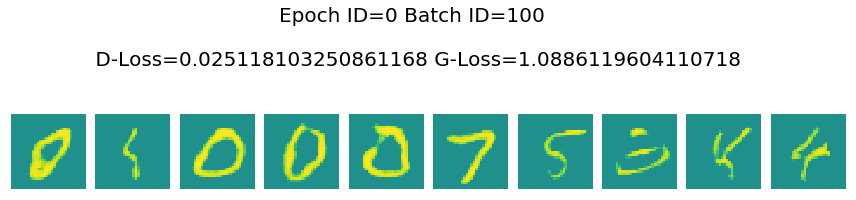

Epoch ID=0 Batch ID=200 

 D-Loss=0.04111599549651146 G-Loss=1.072354793548584


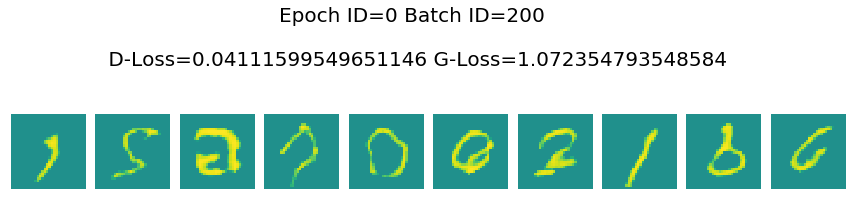

Epoch ID=0 Batch ID=300 

 D-Loss=0.12222452461719513 G-Loss=1.7494585514068604


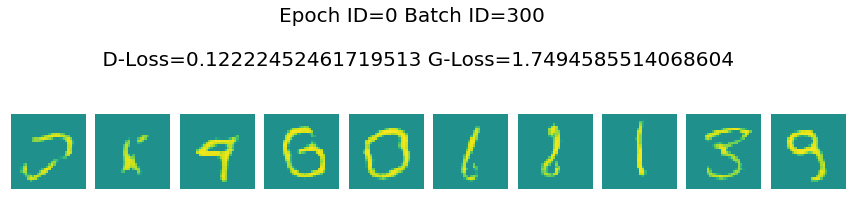

Epoch ID=0 Batch ID=400 

 D-Loss=0.03211722522974014 G-Loss=1.1673145294189453


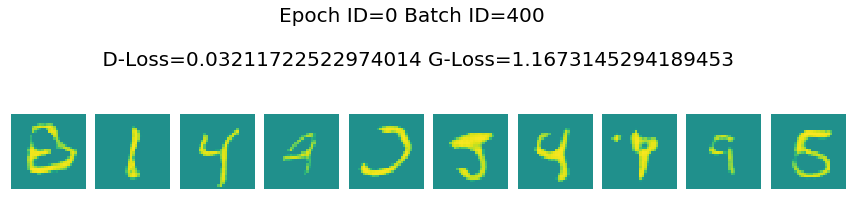

Epoch ID=0 Batch ID=500 

 D-Loss=0.047060541808605194 G-Loss=0.5280996561050415


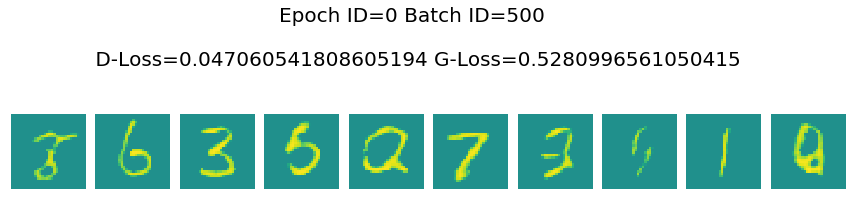

Epoch ID=0 Batch ID=600 

 D-Loss=0.09174442291259766 G-Loss=1.179750680923462


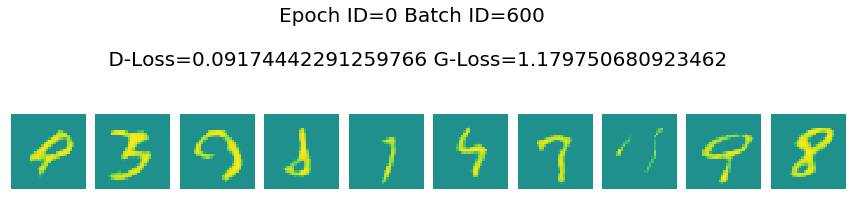

Epoch ID=0 Batch ID=700 

 D-Loss=0.14714649319648743 G-Loss=0.9001613855361938


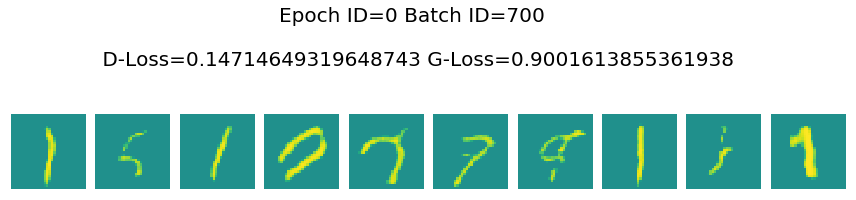

KeyboardInterrupt: 

In [10]:
#Start Training
losses = [[], []]
#plt.ion()
now = 0
#训练100轮
for pass_id in range(100):
    for batch_id, (data, target) in enumerate(dataloader):
        ############################
        # (1) Update D network: minimize log(D(x)) + log(1 - D(G(z)))
        ###########################

        optimizerD.clear_grad()

        real_img = data
        bs_size = real_img.shape[0]
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype='float32')#生成(32,1,1,1)的全为1的标签
        real_out = netD(real_img)#预测样本
        errD_real = loss(real_out, label)#使真实样本尽可能被判别为真
        errD_real.backward()

        noise = paddle.randn([bs_size, 100, 1, 1], 'float32')
        fake_img = netG(noise)#生成样本
        label = paddle.full((bs_size, 1, 1, 1), fake_label, dtype='float32')#生成样本标签设为0
        fake_out = netD(fake_img.detach())#生成样本的预测值
        errD_fake = loss(fake_out,label)#使生成样本尽可能被判别为假
        errD_fake.backward()

        optimizerD.step()
        # optimizerD.clear_grad()
        #D Loss
        errD = errD_real + errD_fake
        losses[0].append(errD.numpy()[0])

        ############################
        # (2) Update G network: minimize log(D(G(z)))
        ###########################
        optimizerG.clear_grad()

        noise = paddle.randn([bs_size, 100, 1, 1],'float32')
        fake = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)#使生成样本尽可能“真实”
        errG.backward()

        optimizerG.step()
        # optimizerG.clear_grad()

        losses[1].append(errG.numpy()[0])


        ############################
        # visualize
        ###########################
        #每隔100批可视化一次生成图像
        if batch_id % 100 == 0:
            generated_image = netG(noise).numpy()#(bs,1,32,32)
            imgs = []
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    image = generated_image[i].transpose()#(32,32,1)
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,0,2))#高宽互换
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id, batch_id,
                 errD.numpy()[0], errG.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', pass_id, batch_id), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
    #保存生成器的权重                    
    paddle.save(netG.state_dict(), "work/generator.params")

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 